In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.data_util import load_augmented_example
from src.evaluation import DAP_SAP_MAP_kde, hist_AP, plot_SAP_MAP

import tensorflow as tf

from sklearn.model_selection import train_test_split
import glob
import json
import os

import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

2024-06-21 12:00:14.080305: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 12:00:14.717638: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Load training and validation data**

![](images/hist_pig_samples_aug.png)

In [2]:
pigs = ["P_{0:02d}_PulHyp".format(i) for i in range(1, 11)]
print(pigs)
# load_path = "/data/PulHypStudie_Check_npz_SNR30/"
# load_path = "/data/PulHypStudie_Check_npz_SNR20/"
load_path = "/data/PulHypStudie_Check_npz_SNR10/"

['P_01_PulHyp', 'P_02_PulHyp', 'P_03_PulHyp', 'P_04_PulHyp', 'P_05_PulHyp', 'P_06_PulHyp', 'P_07_PulHyp', 'P_08_PulHyp', 'P_09_PulHyp', 'P_10_PulHyp']


In [3]:
X_train, y_train, clrs_pig_train = load_augmented_example(
    load_path, pigs, sample_skip=500, load_samples="upwards"
)

Selected 14500 from /data/PulHypStudie_Check_npz_SNR10/P_01_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_SNR10/P_01_PulHyp/sample_014999.npz from pig P_01_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_SNR10/P_02_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_SNR10/P_02_PulHyp/sample_014999.npz from pig P_02_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_SNR10/P_03_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_SNR10/P_03_PulHyp/sample_014999.npz from pig P_03_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_SNR10/P_04_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_SNR10/P_04_PulHyp/sample_014999.npz from pig P_04_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_SNR10/P_05_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_SNR10/P_05_PulHyp/sample_014999.npz from pig P_05_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_SNR10/P_06_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_SNR10/P_

In [4]:
X_valid, y_valid, clrs_pig_valid = load_augmented_example(
    load_path, pigs, sample_skip=500, load_samples="downwards"
)

Selected 500 from /data/PulHypStudie_Check_npz_SNR10/P_01_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_SNR10/P_01_PulHyp/sample_000499.npz from pig P_01_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_SNR10/P_02_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_SNR10/P_02_PulHyp/sample_000499.npz from pig P_02_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_SNR10/P_03_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_SNR10/P_03_PulHyp/sample_000499.npz from pig P_03_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_SNR10/P_04_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_SNR10/P_04_PulHyp/sample_000499.npz from pig P_04_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_SNR10/P_05_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_SNR10/P_05_PulHyp/sample_000499.npz from pig P_05_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_SNR10/P_06_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_SNR10/P_06_PulHyp/sa

In [5]:
print(
    X_train.shape,
    X_valid.shape,
    y_train.shape,
    y_valid.shape,
    clrs_pig_train.shape,
    clrs_pig_valid.shape,
)

(145000, 64, 1024, 1) (5000, 64, 1024, 1) (145000, 3) (5000, 3) (145000, 3) (5000, 3)


**PCA**

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(
    X_valid.reshape(X_valid.shape[0], X_valid.shape[1] * X_valid.shape[2])
)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [7]:
pigs_int = [int(c[0][4:6]) for c in clrs_pig_valid]

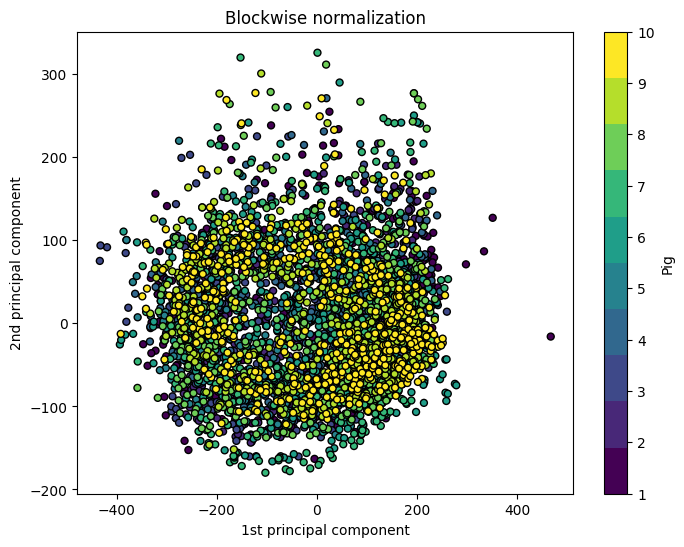

In [8]:
cmap = plt.get_cmap("viridis", np.max(pigs_int) - np.min(pigs_int) + 1)

plt.figure(figsize=(8, 6))
plt.title("Blockwise normalization")
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1], c=pigs_int, cmap=cmap, edgecolor="k", s=25
)

c_bar = plt.colorbar(scatter, ticks=np.arange(np.min(pigs_int), np.max(pigs_int) + 1))
c_bar.set_label("Pig")
c_bar.set_ticks(np.arange(np.min(pigs_int), np.max(pigs_int) + 1))

plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.show()

## Tuning - Automatic

mse


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 1024, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 57, 1017, 8)    │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 57, 1017, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 508, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 501, 4)     │         2,052 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 21, 501, 4)     │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 250, 4)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 243, 2)      │           514 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 3, 243, 2)      │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 121, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 242)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,889 (73.79 KB)

 Trainable params: 18,861 (73.68 KB)

 Non-trainable params: 28 (112.00 B)

Epoch 1/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.5323 - loss: 0.0488 - val_accuracy: 0.6022 - val_loss: 0.0055
Epoch 2/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.6749 - loss: 0.0042 - val_accuracy: 0.7570 - val_loss: 0.0026
Epoch 3/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.7610 - loss: 0.0019 - val_accuracy: 0.8030 - val_loss: 0.0015
Epoch 4/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.8119 - loss: 0.0012 - val_accuracy: 0.8422 - val_loss: 0.0010
Epoch 5/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.8429 - loss: 8.5555e-04 - val_accuracy: 0.8544 - val_loss: 5.8666e-04
Epoch 6/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.8630 - loss: 6.4436e-04 - val_accuracy: 0.8752 - val_loss: 6.2392e-04
Epoch 7/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.8783 - loss: 5.1807e-04 - val_accuracy: 0.8696 - val_loss: 5.2670e-04
Epoch 8/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/s

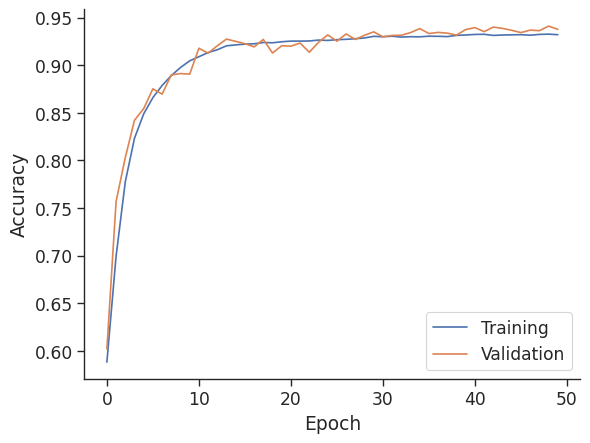

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Model: 43
157/157 - 1s - 6ms/step - accuracy: 0.9376 - loss: 1.4291e-04


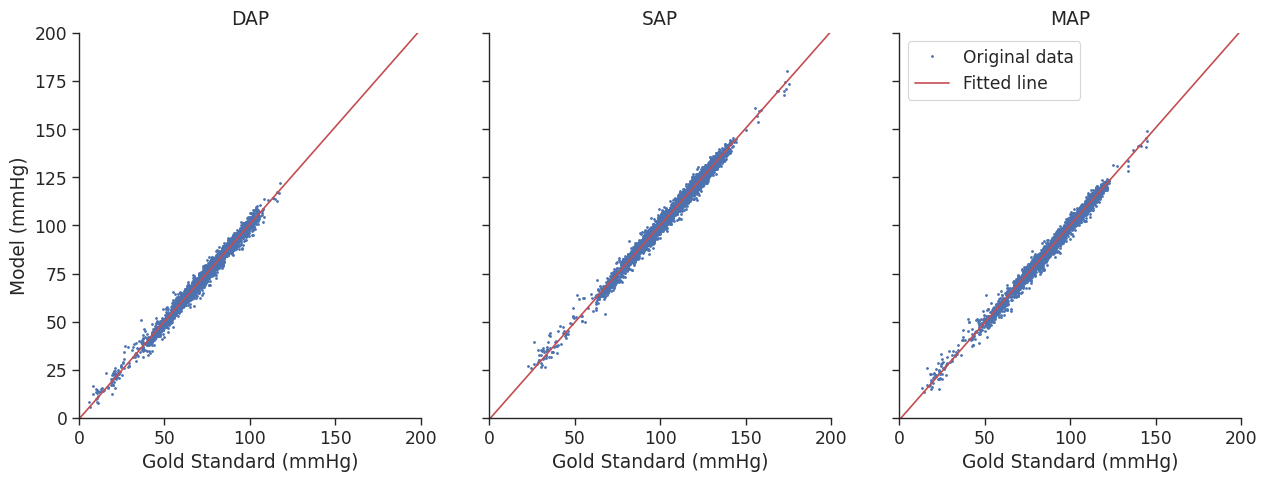

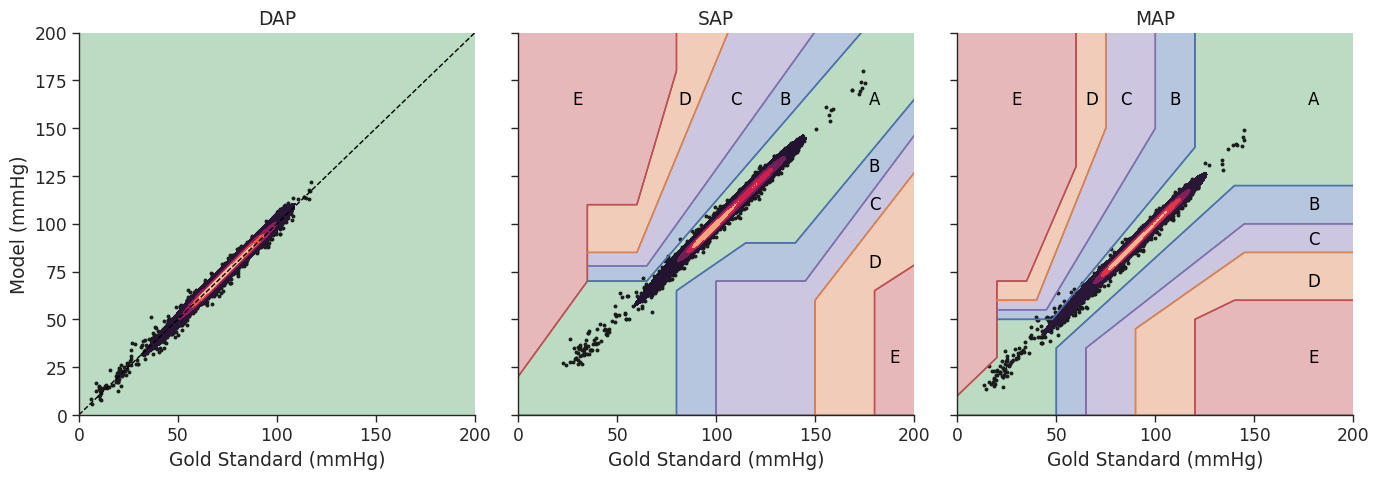

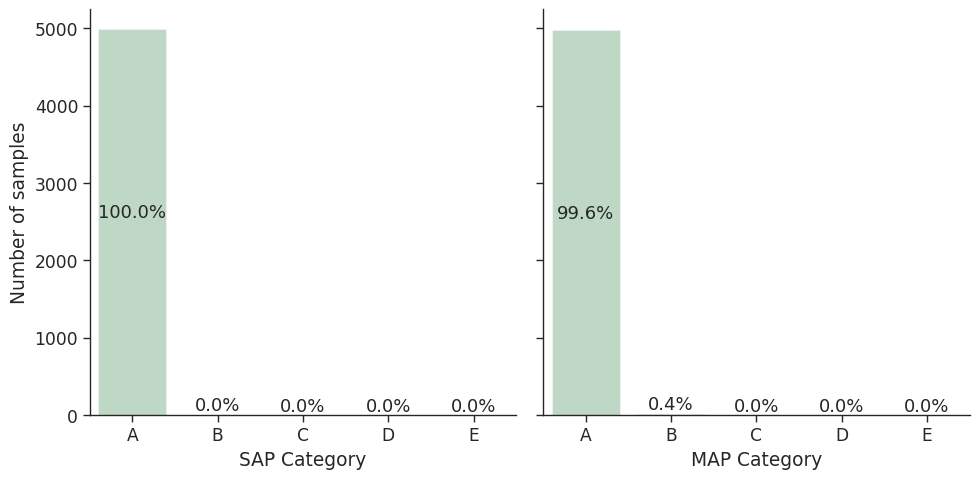

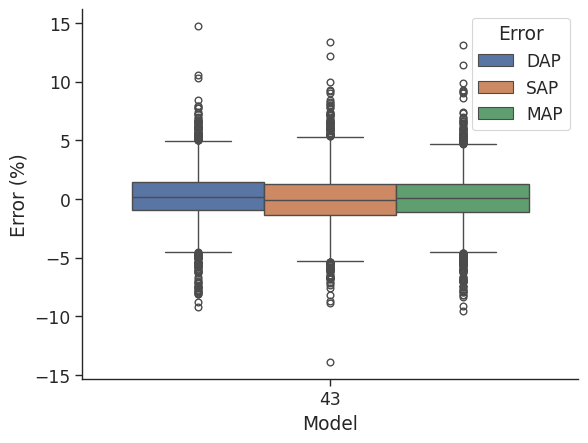

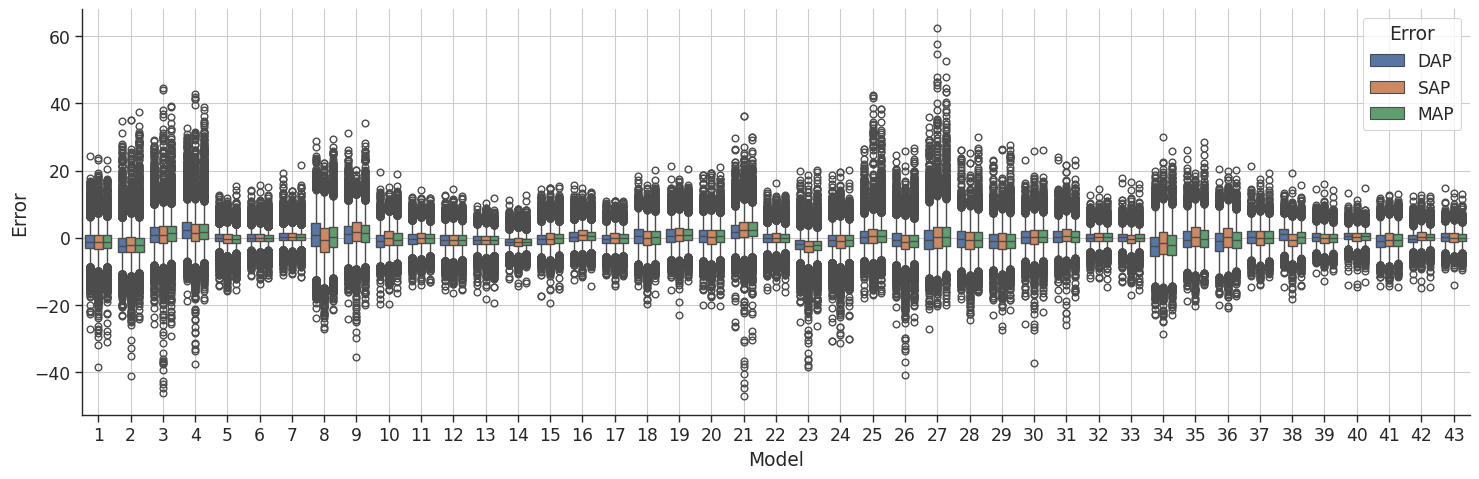

mae


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 1024, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 57, 1017, 8)    │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 57, 1017, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 28, 508, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 21, 501, 4)     │         2,052 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 21, 501, 4)     │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 250, 4)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 243, 2)      │           514 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 3, 243, 2)      │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 121, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 242)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,889 (73.79 KB)

 Trainable params: 18,861 (73.68 KB)

 Non-trainable params: 28 (112.00 B)

Epoch 1/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.5734 - loss: 0.1255 - val_accuracy: 0.7878 - val_loss: 0.0362
Epoch 2/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.7977 - loss: 0.0317 - val_accuracy: 0.8230 - val_loss: 0.0241
Epoch 3/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.8216 - loss: 0.0244 - val_accuracy: 0.8354 - val_loss: 0.0216
Epoch 4/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.8375 - loss: 0.0209 - val_accuracy: 0.8602 - val_loss: 0.0179
Epoch 5/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.8521 - loss: 0.0185 - val_accuracy: 0.8502 - val_loss: 0.0175
Epoch 6/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.8607 - loss: 0.0172 - val_accuracy: 0.8660 - val_loss: 0.0157
Epoch 7/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.8710 - loss: 0.0161 - val_accuracy: 0.8738 - val_loss: 0.0148
Epoch 8/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.8744 -

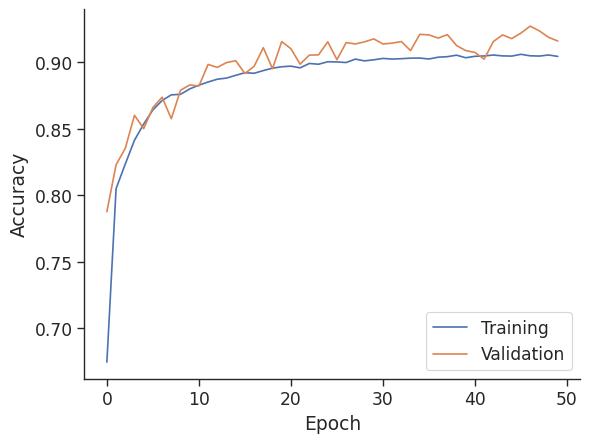

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Model: 44
157/157 - 1s - 6ms/step - accuracy: 0.9160 - loss: 0.0112


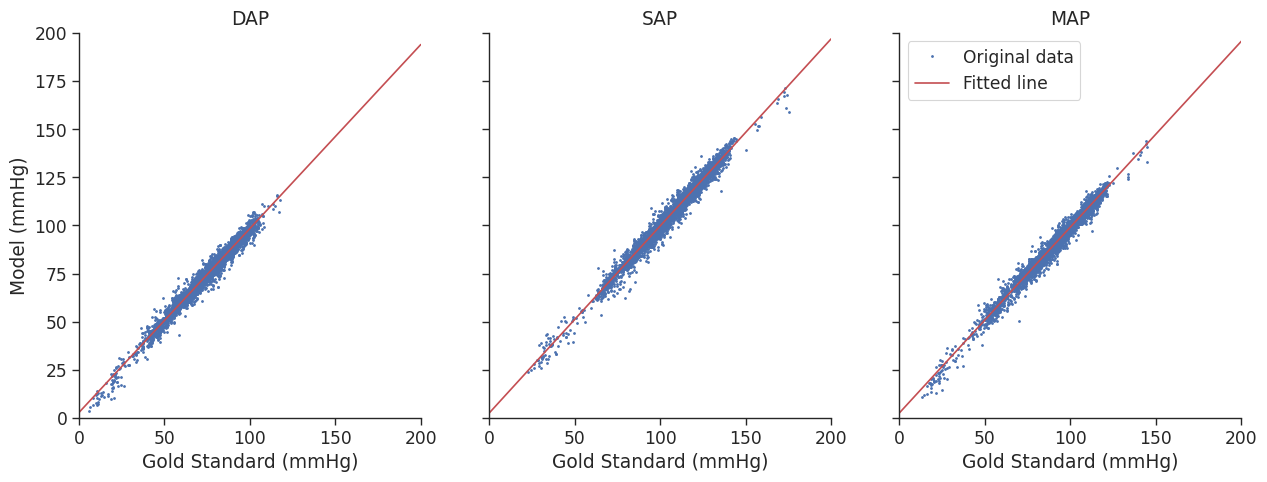

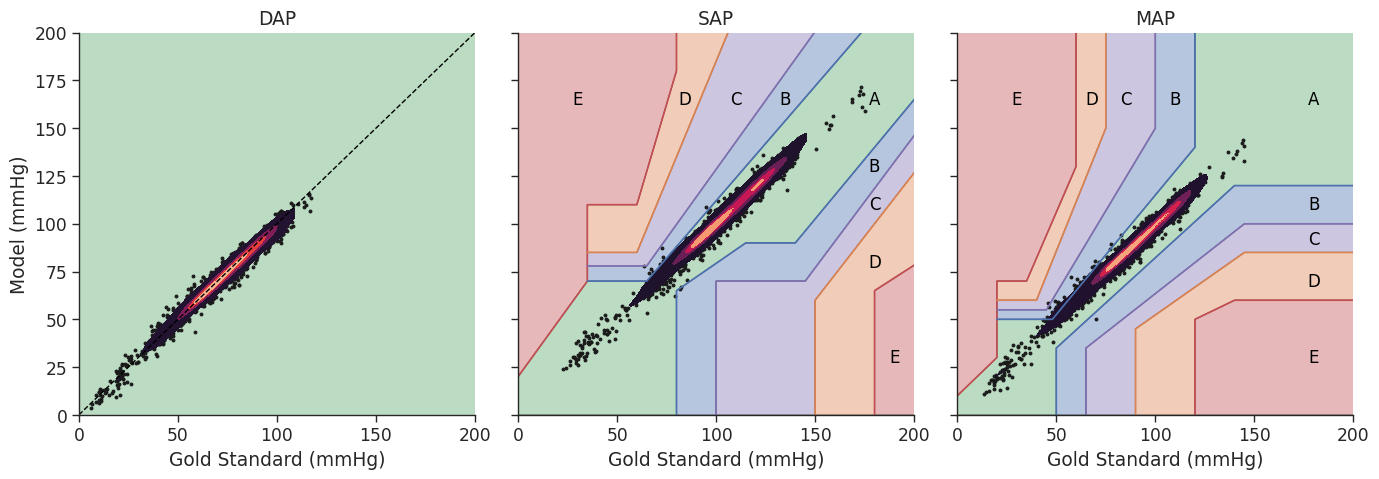

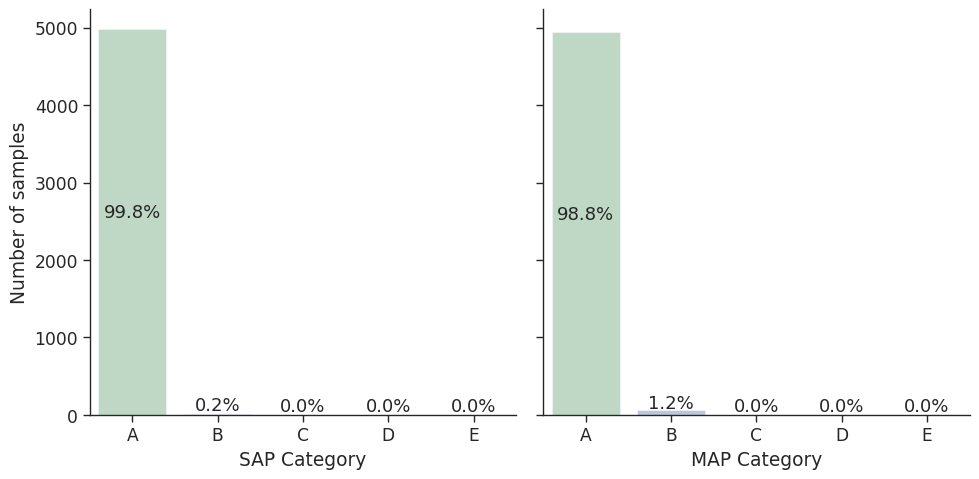

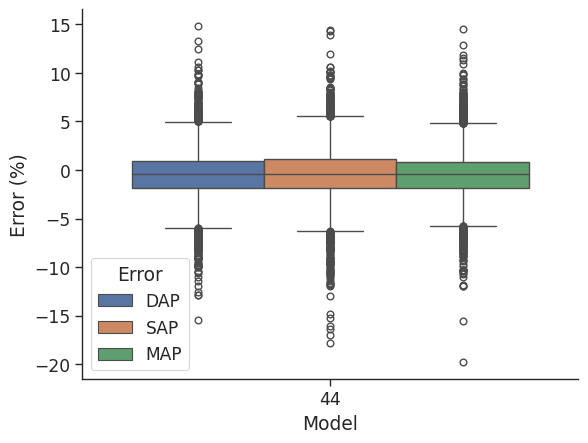

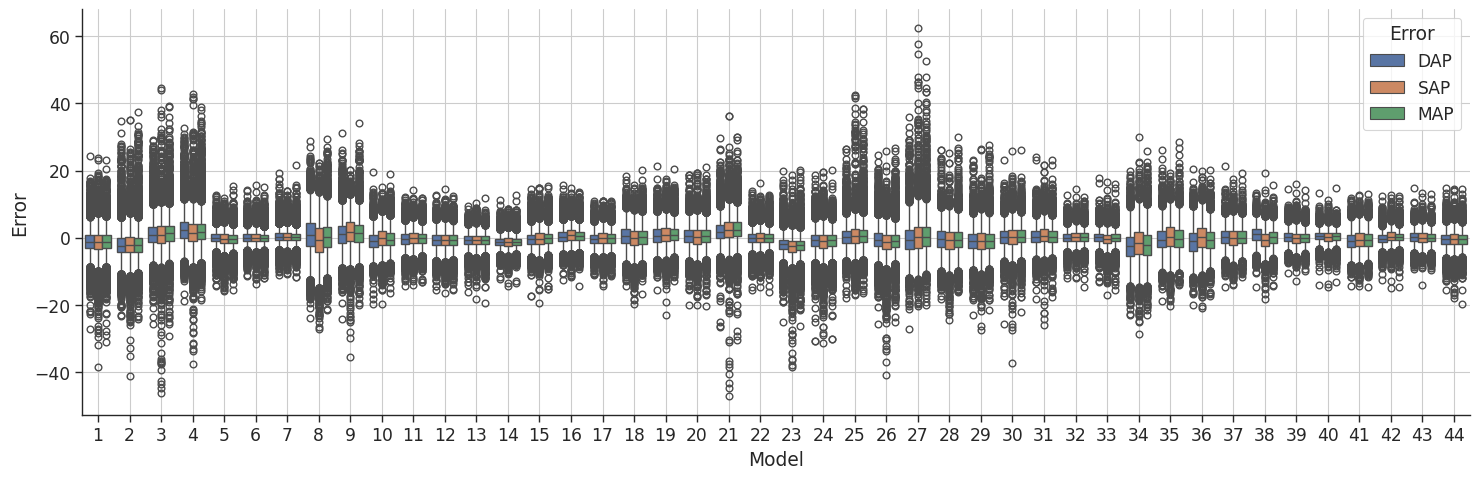

In [11]:
## DATA:  load_path = "/data/PulHypStudie_Check_npz_SNR30/"
# | model  1: epochs = 30, batch_size = 64, kernels = 3, filters = [8, 4, 2], opt = adam, loss = mae|
# | model  2: epochs = 30, batch_size = 64, kernels = 4, filters = [8, 4, 2], opt = adam, loss = mae|
# | model  3: epochs = 30, batch_size = 64, kernels = 5, filters = [8, 4, 2], opt = adam, loss = mae|
# | model  4: epochs = 40, batch_size = 64, kernels = 6, filters = [8, 4, 2], opt = adam, loss = mae|
# | model  5: epochs = 50, batch_size = 64, kernels = 7, filters = [8, 4, 2], opt = adam, loss = mae|
# | model  6: epochs = 50, batch_size = 64, kernels = 8, filters = [8, 4, 2], opt = adam, loss = mae|
# | model  7: epochs = 50, batch_size = 64, kernels = 9, filters = [8, 4, 2], opt = adam, loss = mae|

# | model  8: epochs = 30, batch_size = 64, kernels = 3, filters = [8, 4, 2], opt = adam, loss = mse|
# | model  9: epochs = 30, batch_size = 64, kernels = 4, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 10: epochs = 30, batch_size = 64, kernels = 5, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 11: epochs = 40, batch_size = 64, kernels = 6, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 12: epochs = 50, batch_size = 64, kernels = 7, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 13: epochs = 50, batch_size = 64, kernels = 8, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 14: epochs = 50, batch_size = 64, kernels = 9, filters = [8, 4, 2], opt = adam, loss = mse|<-


# | model 15: epochs = 30, batch_size = 48, kernels = 9, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 16: epochs = 40, batch_size = 32, kernels = 9, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 17: epochs = 50, batch_size = 16, kernels = 9, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 18: epochs = 50, batch_size = 8, kernels = 9, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 19: epochs = 50, batch_size = 4, kernels = 9, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 20: epochs = 50, batch_size = 2, kernels = 9, filters = [8, 4, 2], opt = adam, loss = mse|

# | model 21: epochs = 50, batch_size = 512, kernels = 8, filters = [8, 4, 2], opt = adam, loss = mae|
# | model 22: epochs = 50, batch_size = 256, kernels = 8, filters = [8, 4, 2], opt = adam, loss = mae|
# | model 23: epochs = 50, batch_size = 128, kernels = 8, filters = [8, 4, 2], opt = adam, loss = mae|
# | model 24: epochs = 50, batch_size = 32, kernels = 8, filters = [8, 4, 2], opt = adam, loss = mae|
# | model 25: epochs = 50, batch_size = 16, kernels = 8, filters = [8, 4, 2], opt = adam, loss = mae|
# | model 26: epochs = 50, batch_size = 8, kernels = 8, filters = [8, 4, 2], opt = adam, loss = mae|

## DATA:  load_path = "/data/PulHypStudie_Check_npz_SNR20/"

# | model 27: epochs = 50, batch_size = 64, kernels = 3, filters = [8, 4, 2], opt = adam, loss = mae|
# | model 28: epochs = 50, batch_size = 64, kernels = 4, filters = [8, 4, 2], opt = adam, loss = mae|
# | model 29: epochs = 50, batch_size = 64, kernels = 5, filters = [8, 4, 2], opt = adam, loss = mae|
# | model 30: epochs = 50, batch_size = 64, kernels = 6, filters = [8, 4, 2], opt = adam, loss = mae|
# | model 31: epochs = 50, batch_size = 64, kernels = 7, filters = [8, 4, 2], opt = adam, loss = mae|
# | model 32: epochs = 50, batch_size = 64, kernels = 8, filters = [8, 4, 2], opt = adam, loss = mae|
# | model 33: epochs = 50, batch_size = 64, kernels = 9, filters = [8, 4, 2], opt = adam, loss = mae|

# | model 34: epochs = 50, batch_size = 64, kernels = 3, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 35: epochs = 50, batch_size = 64, kernels = 4, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 36: epochs = 50, batch_size = 64, kernels = 5, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 37: epochs = 50, batch_size = 64, kernels = 6, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 38: epochs = 50, batch_size = 64, kernels = 7, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 39: epochs = 50, batch_size = 64, kernels = 8, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 40: epochs = 50, batch_size = 64, kernels = 9, filters = [8, 4, 2], opt = adam, loss = mse| <-

## DATA: load_path = "/data/PulHypStudie_Check_npz_SNR10/"

# | model 41: epochs = 50, batch_size = 64, kernels = 8, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 42: epochs = 50, batch_size = 64, kernels = 8, filters = [8, 4, 2], opt = adam, loss = mae|

# | model 43: epochs = 50, batch_size = 64, kernels = 9, filters = [8, 4, 2], opt = adam, loss = mse|
# | model 44: epochs = 50, batch_size = 64, kernels = 9, filters = [8, 4, 2], opt = adam, loss = mae|


for tuning_parameter in ["mse", "mae"]:  # model 43-44 -> tuning lf
    print(tuning_parameter)
    optimizer = "adam"
    loss_fct = tuning_parameter
    kernels = 8
    filters = [8, 4, 2]
    batch_size = 64
    epochs = 50

    def AP_model(input_shape, kernel, filters, output_shape=3):
        model_input = tf.keras.layers.Input(shape=input_shape)
        x = model_input

        for fltr in filters:
            x = tf.keras.layers.Conv2D(
                filters=fltr, kernel_size=kernel, activation="relu"
            )(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.MaxPooling2D((2, 2))(x)

        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(64, activation="relu")(x)
        model_output = tf.keras.layers.Dense(output_shape)(x)

        return tf.keras.models.Model(model_input, model_output)

    model = AP_model(input_shape=(64, 1024, 1), kernel=kernels, filters=filters)
    model.compile(optimizer=optimizer, loss=loss_fct, metrics=["accuracy"])
    model.summary()

    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, y_valid),
    )

    plt.plot(history.history["accuracy"], label="Training")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.show()

    dap_factor = 180
    sap_factor = 180
    map_factor = 160
    y_true = np.zeros(y_valid.shape)

    y_true[:, 0] = y_valid[:, 0] * dap_factor  # dap normalization
    y_true[:, 1] = y_valid[:, 1] * sap_factor  # sap normalization
    y_true[:, 2] = y_valid[:, 2] * map_factor  # map normalization

    y_pred = model.predict(X_valid)  # X_valid
    y_pred[:, 0] = y_pred[:, 0] * dap_factor  # dap normalization
    y_pred[:, 1] = y_pred[:, 1] * sap_factor  # sap normalization
    y_pred[:, 2] = y_pred[:, 2] * map_factor  # map normalization

    m_idx = len(glob.glob("models/model_aug/*.h5")) + 1
    print("Model:", m_idx)
    np.savez(
        f"models/model_aug/model_{m_idx}.npz",
        accuracy=history.history["accuracy"],
        loss=history.history["loss"],
        val_accuracy=history.history["val_accuracy"],
        val_loss=history.history["val_loss"],
    )

    test_loss, test_acc = model.evaluate(X_valid, y_valid, verbose=2)

    accs_dct = {
        "model": m_idx,
        "test_loss": test_loss,
        "test_acc": test_acc,
    }

    lst_sqrs = ["DAP_m", "DAP_n", "SAP_m", "SAP_n", "MAP_m", "MAP_n"]
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    ax[0].set_ylabel("Model (mmHg)")
    for ap in range(y_pred.shape[1]):
        y = y_true[:, ap]
        x = y_pred[:, ap]
        A = np.vstack([y, np.ones(len(y))]).T
        m, n = np.linalg.lstsq(A, x, rcond=None)[0]

        accs_dct[lst_sqrs[ap * 2]] = m
        accs_dct[lst_sqrs[ap * 2 + 1]] = n

        x_f = np.linspace(0, 200)
        ax[ap].set_xlabel("Gold Standard (mmHg)")
        ax[ap].set_xlim(0, 200)
        ax[ap].set_ylim(0, 200)
        ax[ap].set_title(lst_sqrs[ap * 2][:3])
        ax[ap].plot(y, x, "o", label="Original data", markersize=1)
        ax[ap].plot(x_f, m * x_f + n, "r", label="Fitted line")
    plt.legend()
    plt.show()

    with open(f"models/model_aug/acc_{m_idx}.json", "w") as json_file:
        json.dump(accs_dct, json_file)

    DAP_SAP_MAP_kde(y_pred, y_true)
    df_SAP = hist_AP(y_pred, y_true, AP="SAP")
    df_MAP = hist_AP(y_pred, y_true, AP="MAP")

    plot_SAP_MAP(df_SAP, df_MAP)
    df_SAP.to_csv(f"models/model_aug/df_SAP_{m_idx}.csv", index=False)
    df_MAP.to_csv(f"models/model_aug/df_MAP_{m_idx}.csv", index=False)
    acc_measure = dict(Model=list(), Error_val=list(), Error=list())

    data_append = []
    Errors_names = ["DAP", "SAP", "MAP"]

    for pred, true in zip(y_pred, y_true):
        err = pred - true
        for e in range(3):
            data_append.append(
                dict(Model=m_idx, Error_val=err[e], Error=Errors_names[e])
            )
    for item in data_append:
        for key, value in item.items():
            acc_measure[key].append(value)

    acc_measure_df = pd.DataFrame(acc_measure).dropna()
    acc_measure_df.to_csv(f"models/model_aug/sgl_box_m_{m_idx}.csv", index=False)

    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)
    sns.set_context(context="paper", font_scale=1.4)

    sns.boxplot(
        x="Model", y="Error_val", data=acc_measure_df, hue="Error", showfliers=True
    )
    plt.ylabel("Error (%)")
    # plt.xlabel("Model Iteration")
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)
    sns.set_context(context="paper", font_scale=1.4)

    combined_df = pd.concat(
        [
            pd.read_csv(f_csvs)
            for f_csvs in np.sort(glob.glob("models/model_aug/sgl_box*.csv"))
        ],
        ignore_index=True,
    )
    combined_df = pd.DataFrame(combined_df)

    plt.figure(figsize=(15, 5))
    sns.boxplot(
        x="Model",
        y="Error_val",
        data=combined_df,
        hue="Error",
        showfliers=True,
    )  #  violinplot: , split=True
    plt.ylabel("Error")
    plt.grid(True)
    plt.tight_layout()
    # plt.xlim([-0.5, 25])
    plt.show()

    model.save_weights(f"models/model_aug/model_{m_idx}.weights.h5")

In [1]:
combined_df = pd.concat(
    [
        pd.read_csv(f_csvs)
        for f_csvs in np.sort(glob.glob("models/model_aug/sgl_box*.csv"))
    ],
    ignore_index=True,
)
combined_df = pd.DataFrame(combined_df)

plt.figure(figsize=(15, 5))
sns.boxplot(
    x="Model",
    y="Error_val",
    data=combined_df,
    hue="Error",
    showfliers=False,
)  #  violinplot: , split=True
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
# plt.xlim([-0.5, 25])
plt.show()

NameError: name 'pd' is not defined

## Tuning - Manual

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
)

Epoch 1/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.6362 - loss: 0.1206 - val_accuracy: 0.7787 - val_loss: 0.0316
Epoch 2/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.7859 - loss: 0.0336 - val_accuracy: 0.7807 - val_loss: 0.0269
Epoch 3/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.8034 - loss: 0.0272 - val_accuracy: 0.8255 - val_loss: 0.0257
Epoch 4/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.8285 - loss: 0.0249 - val_accuracy: 0.8350 - val_loss: 0.0321
Epoch 5/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.8387 - loss: 0.0233 - val_accuracy: 0.8380 - val_loss: 0.0254
Epoch 6/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.8420 - loss: 0.0220 - val_accuracy: 0.8373 - val_loss: 0.0209
Epoch 7/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.8449 - loss: 0.0209 - val_accuracy: 0.8357 - val_loss: 0.0258
Epoch 8/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.8463 -

In [ ]:
plt.plot(history.history["accuracy"], label="Training")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

**Predict test data**

- `y_pred` ...  Predicted data in true AP value range
- `y_true` ...  True AP data in true value range
- `y_test` ...  True AP data in scaled value range

In [ ]:
dap_factor = 180
sap_factor = 180
map_factor = 160
y_true = np.zeros(y_valid.shape)

y_true[:, 0] = y_valid[:, 0] * dap_factor  # dap normalization
y_true[:, 1] = y_valid[:, 1] * sap_factor  # sap normalization
y_true[:, 2] = y_valid[:, 2] * map_factor  # map normalization

In [ ]:
y_pred = model.predict(X_valid)  # X_valid
y_pred[:, 0] = y_pred[:, 0] * dap_factor  # dap normalization
y_pred[:, 1] = y_pred[:, 1] * sap_factor  # sap normalization
y_pred[:, 2] = y_pred[:, 2] * map_factor  # map normalization

In [ ]:
m_idx = len(glob.glob("models/model_aug/*.h5")) + 1
print("Model:", m_idx)
np.savez(
    f"models/model_aug/model_{m_idx}.npz",
    accuracy=history.history["accuracy"],
    loss=history.history["loss"],
    val_accuracy=history.history["val_accuracy"],
    val_loss=history.history["val_loss"],
)

Test data loss, accuracy, and least-squares solution $$y = mx + n$$ for SAP, MAP and DAP predictions.

In [ ]:
test_loss, test_acc = model.evaluate(X_valid, y_valid, verbose=2)

accs_dct = {
    "model": m_idx,
    "test_loss": test_loss,
    "test_acc": test_acc,
}

lst_sqrs = ["DAP_m", "DAP_n", "SAP_m", "SAP_n", "MAP_m", "MAP_n"]
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
ax[0].set_ylabel("Model (mmHg)")
for ap in range(y_pred.shape[1]):
    y = y_true[:, ap]
    x = y_pred[:, ap]
    A = np.vstack([y, np.ones(len(y))]).T
    m, n = np.linalg.lstsq(A, x, rcond=None)[0]

    accs_dct[lst_sqrs[ap * 2]] = m
    accs_dct[lst_sqrs[ap * 2 + 1]] = n

    x_f = np.linspace(0, 200)
    ax[ap].set_xlabel("Gold Standard (mmHg)")
    ax[ap].set_xlim(0, 200)
    ax[ap].set_ylim(0, 200)
    ax[ap].set_title(lst_sqrs[ap * 2][:3])
    ax[ap].plot(y, x, "o", label="Original data", markersize=1)
    ax[ap].plot(x_f, m * x_f + n, "r", label="Fitted line")
plt.legend()
plt.show()

with open(f"models/model_aug/acc_{m_idx}.json", "w") as json_file:
    json.dump(accs_dct, json_file)

In [ ]:
DAP_SAP_MAP_kde(y_pred, y_true)

In [ ]:
df_SAP = hist_AP(y_pred, y_true, AP="SAP")
df_MAP = hist_AP(y_pred, y_true, AP="MAP")

plot_SAP_MAP(df_SAP, df_MAP)

In [ ]:
df_SAP.to_csv(f"models/model_aug/df_SAP_{m_idx}.csv", index=False)
df_MAP.to_csv(f"models/model_aug/df_MAP_{m_idx}.csv", index=False)

In [ ]:
acc_measure = dict(Model=list(), Error_val=list(), Error=list())

data_append = []
Errors_names = ["DAP", "SAP", "MAP"]

for pred, true in zip(y_pred, y_true):
    err = pred - true
    for e in range(3):
        data_append.append(dict(Model=m_idx, Error_val=err[e], Error=Errors_names[e]))
for item in data_append:
    for key, value in item.items():
        acc_measure[key].append(value)

acc_measure_df = pd.DataFrame(acc_measure).dropna()
acc_measure_df.to_csv(f"models/model_aug/sgl_box_m_{m_idx}.csv", index=False)
acc_measure_df

In [ ]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_context(context="paper", font_scale=1.4)

sns.boxplot(x="Model", y="Error_val", data=acc_measure_df, hue="Error", showfliers=True)
plt.ylabel("Error (%)")
# plt.xlabel("Model Iteration")

In [ ]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_context(context="paper", font_scale=1.4)

combined_df = pd.concat(
    [
        pd.read_csv(f_csvs)
        for f_csvs in np.sort(glob.glob("models/model_aug/sgl_box*.csv"))
    ],
    ignore_index=True,
)
combined_df = pd.DataFrame(combined_df)

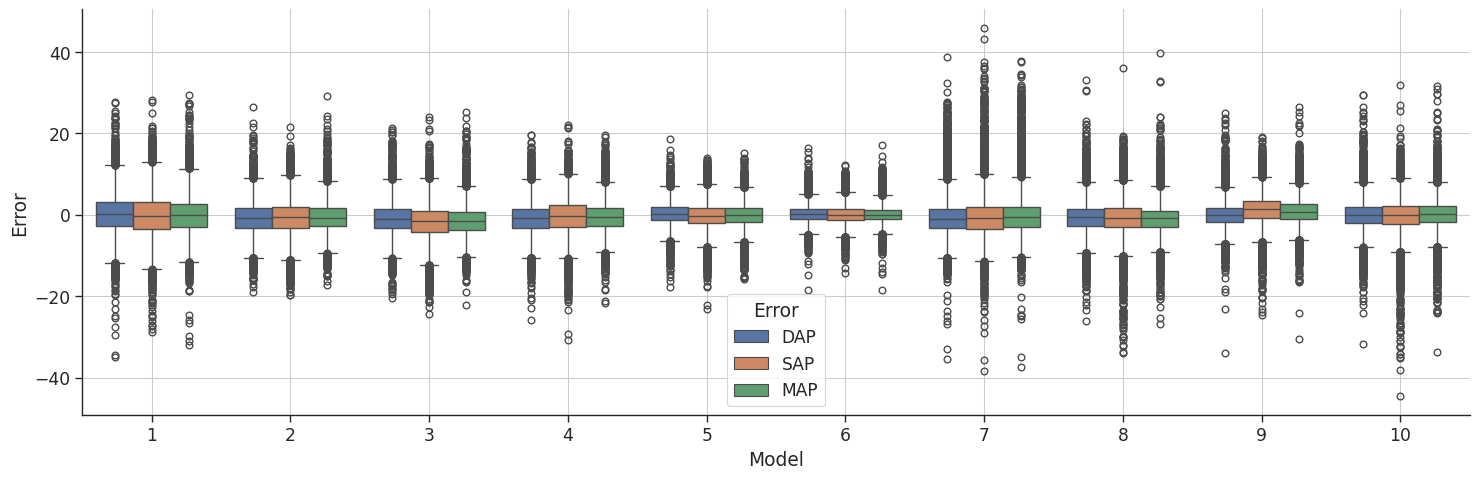

In [179]:
plt.figure(figsize=(15, 5))
sns.boxplot(
    x="Model",
    y="Error_val",
    data=combined_df,
    hue="Error",
    showfliers=True,
)  #  violinplot: , split=True
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
# plt.xlim([-0.5, 25])
plt.show()
# plt.figure(figsize=(15,5))
# sns.boxplot(
#    x="Model",
#    y="Error_val",
#    data=combined_df,
#    hue="Error",
#    showfliers=False,

# )  #  violinplot: , split=True
# plt.ylabel("Error")
# plt.grid(True)
# plt.tight_layout()
##plt.xlim([-0.5, 25])
# plt.show()

In [164]:
# Wanna save the weights?
model.save_weights(f"models/model_aug/model_{m_idx}.weights.h5")

___